# Claim 1 : Analysis

Here is the code for reproduction of claim 1, which corresponds to experiment 1.

In [1]:
# move to notebooks directory
%cd ..

/home/bro/Documents/FRI/MLDS/repro/MLDS/notebooks


In [2]:
## IMPORTS

# import standard data science libraries
import numpy as np
import pandas as pd

# import ggplot for graphing
import plotnine
from plotnine import ggplot, aes, geom_line, geom_point, geom_errorbar, \
                     facet_wrap, position_dodge, theme, geom_violin, xlab, ylab, \
                     coord_flip, geom_bar, element_text, scale_x_discrete, scale_fill_manual, \
                     geom_hline, xlim, ylim, scale_color_discrete, geom_text, position_stack, \
                     geom_hline, position_dodge, geom_text

# suppress any warnings
import warnings

# import helper functions
from utils.helper_functions import plot_fig_4, likelihood_of_being_better, likelihood_of_improvement, \
                             plot_distribution, check_top_scores, check_improvement, check_heuristic, \
                             plot_comparison, plot_comparison_x, check_improvement_by_x, comparison_rnd_by_x,\
                             make_modelling_imp_dataset, make_modelling_rnd_dataset

## CONSTANTS

# 95-percentile
Q_95 = 1.00 

# region of practical equivalence
ROPE = 0.005

TOL_LEAF = 2 # tolarence for deviation from ideal num. of leaves

# default leaf values for regression sqrt(num. of features)
regression_heuristic = {"friedman1": np.floor(10/3),
                  "friedman3": np.floor(4/3),
                  "diabetes-regr": np.floor(10/3),
                  "music": np.floor(117/3),
                  "red-wine": np.floor(11/3),
                  "abalone": np.floor(8/3),
                  "satellite-image": np.floor(36/3),
                  "california-housing": np.floor(8/3)}

# default leaf values for classification sqrt(num. of features)
classification_heuristic = {"heart": np.floor(np.sqrt(15)),
                  "breast-cancer": np.floor(np.sqrt(17)),
                  "haberman": np.floor(np.sqrt(3)),
                  "ionosphere": np.floor(np.sqrt(34)),
                  "diabetes": np.floor(np.sqrt(8)),
                  "german-credit": np.floor(np.sqrt(20)),
                  "juvenile": np.floor(np.sqrt(286)),
                  "recidivism": np.floor(np.sqrt(20))}

# classification dataset order
CLASSIFICATION_ORDER = ["heart", "breast-cancer", "haberman", "ionosphere", "diabetes", "german-credit", "juvenile", "recidivism"]

# regression dataset order
REGRESSION_ORDER = ["friedman1", "friedman3", "diabetes-regr", "music", \
                 "red-wine", "abalone", "satellite-image", "california-housing"]

## Data for modelling

In [3]:
# load datasets
regression = pd.read_csv("results/claim_1_1_dt_comparison_regression.csv")    
classification = pd.read_csv("results/claim_1_1_dt_comparison_classification.csv")
rf = pd.read_csv("results/rf_comparison_classification.csv").drop(['Unnamed: 0'], axis = 1)

# pick only relavant parts for this claim
rf = rf.loc[(rf["algorithm"] == "RF") | (rf["algorithm"] == "HS-RF")]
rf.loc[rf["algorithm"] == "RF"] = rf.loc[rf["algorithm"] == "RF"].replace("RF", " RF")

# save results for bayesian modeling of improvement
make_modelling_imp_dataset(regression, REGRESSION_ORDER, save_to = "modelling/data/any-data.csv")
make_modelling_imp_dataset(classification, CLASSIFICATION_ORDER, save_to = "modelling/data/any-classification.csv")

# save results for bayesian modeling of which algorithm is better
make_modelling_rnd_dataset(regression, REGRESSION_ORDER, save_to = "modelling/data/random-regression.csv")
make_modelling_rnd_dataset(classification, CLASSIFICATION_ORDER, save_to = "modelling/data/random-classification.csv")

# Improvement

## 1.1 Decision trees (DT)

In [4]:
classification_any = pd.read_csv("modelling/data/any-classification.csv")
regression_any = pd.read_csv("modelling/data/any-regression.csv")
regression_any["dataset"] += 8

/home/bro/anaconda3/envs/mlds/lib/python3.10/site-packages/plotnine/utils.py:693: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
/home/bro/anaconda3/envs/mlds/lib/python3.10/site-packages/plotnine/utils.py:694: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
/home/bro/anaconda3/envs/mlds/lib/python3.10/site-packages/plotnine/utils.py:693: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* ind

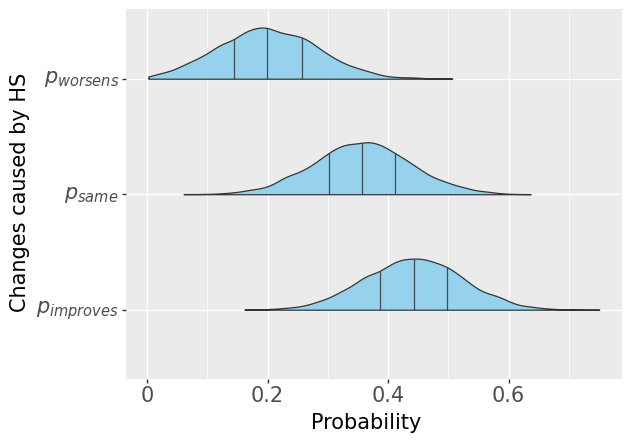

<ggplot: (8779450299080)>

/home/bro/anaconda3/envs/mlds/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 5 x 5 in image.
/home/bro/anaconda3/envs/mlds/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: graphs/imp-dt.png
/home/bro/anaconda3/envs/mlds/lib/python3.10/site-packages/plotnine/utils.py:693: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
/home/bro/anaconda3/envs/mlds/lib/python3.10/site-packages/plotnine/utils.py:694: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use 

In [5]:
any = pd.concat([classification_any, regression_any])
any.to_csv("modelling/data/any.csv")

any = pd.read_csv("modelling/data/any-res.csv")
any = any[["theta_upper[1]", "theta_upper[2]", "theta_upper[3]"]]

disp = pd.melt(any, value_vars=["theta_upper[1]", "theta_upper[2]", "theta_upper[3]"], value_name='sample')
disp.loc[disp.variable == "theta_upper[1]", "variable"] = "$p_{improves}$"
disp.loc[disp.variable == "theta_upper[2]", "variable"] = "$p_{same}$"
disp.loc[disp.variable == "theta_upper[3]", "variable"] = "$p_{worsens}$"

g = (
    ggplot(disp, aes(x="variable", y="sample"))
    + geom_violin(disp, draw_quantiles = [0.25, 0.5, 0.75], fill = "skyblue", alpha = 0.85, style = "right", position = position_dodge())
    # + geom_hline(yintercept = 0, linetype = "dashed", color = "red")
    + theme(text=element_text(size=15))
    + xlab("Changes caused by HS")
    + ylab("Probability")
    # + geom_text(disp_mu, aes(x="parameters", y="value", label = "value_str"), nudge_x = -0.2, size = 10)
    + coord_flip()
    # + facet_wrap("var")
)
display(g)
g.save(filename = "graphs/imp-dt.png", height = 5, width = 5, units = "in", dpi = 1000)

## 1.2 Random Forest (RF)

/home/bro/anaconda3/envs/mlds/lib/python3.10/site-packages/plotnine/utils.py:693: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
/home/bro/anaconda3/envs/mlds/lib/python3.10/site-packages/plotnine/utils.py:694: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
/home/bro/anaconda3/envs/mlds/lib/python3.10/site-packages/plotnine/utils.py:693: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* ind

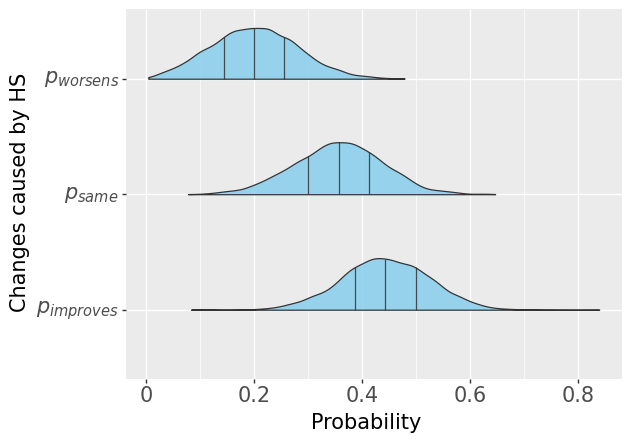

<ggplot: (8779264711320)>

/home/bro/anaconda3/envs/mlds/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 5 x 5 in image.
/home/bro/anaconda3/envs/mlds/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: graphs/imp-rf.png
/home/bro/anaconda3/envs/mlds/lib/python3.10/site-packages/plotnine/utils.py:693: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
/home/bro/anaconda3/envs/mlds/lib/python3.10/site-packages/plotnine/utils.py:694: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use 

In [6]:
any = pd.read_csv("modelling/data/any-rf-res.csv")
any = any[["theta_upper[1]", "theta_upper[2]", "theta_upper[3]"]]

disp = pd.melt(any, value_vars=["theta_upper[1]", "theta_upper[2]", "theta_upper[3]"], value_name='sample')
disp.loc[disp.variable == "theta_upper[1]", "variable"] = "$p_{improves}$"
disp.loc[disp.variable == "theta_upper[2]", "variable"] = "$p_{same}$"
disp.loc[disp.variable == "theta_upper[3]", "variable"] = "$p_{worsens}$"

g = (
    ggplot(disp, aes(x="variable", y="sample"))
    + geom_violin(disp, draw_quantiles = [0.25, 0.5, 0.75], fill = "skyblue", alpha = 0.85, style = "right", position = position_dodge())
    # + geom_hline(yintercept = 0, linetype = "dashed", color = "red")
    + theme(text=element_text(size=15))
    + xlab("Changes caused by HS")
    + ylab("Probability")
    # + geom_text(disp_mu, aes(x="parameters", y="value", label = "value_str"), nudge_x = -0.2, size = 10)
    + coord_flip()
    # + facet_wrap("var")
)
display(g)
g.save(filename = "graphs/imp-rf.png", height = 5, width = 5, units = "in", dpi = 1000)

# Which is better ? 

## 1.1 Decision trees (DT)

/home/bro/anaconda3/envs/mlds/lib/python3.10/site-packages/plotnine/utils.py:693: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
/home/bro/anaconda3/envs/mlds/lib/python3.10/site-packages/plotnine/utils.py:694: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
/home/bro/anaconda3/envs/mlds/lib/python3.10/site-packages/plotnine/utils.py:693: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* ind

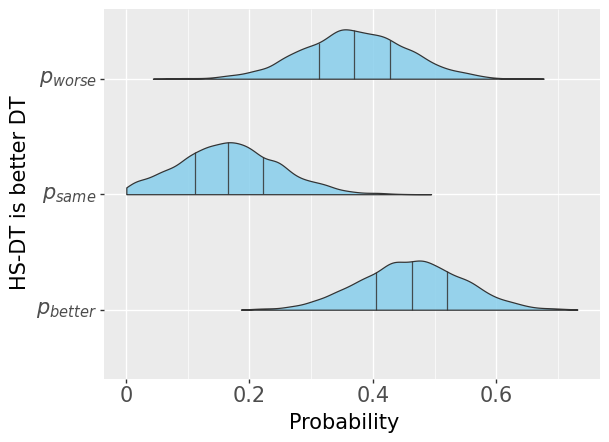

<ggplot: (8779252404723)>

/home/bro/anaconda3/envs/mlds/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 5 x 5 in image.
/home/bro/anaconda3/envs/mlds/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: graphs/rnd-dt.png
/home/bro/anaconda3/envs/mlds/lib/python3.10/site-packages/plotnine/utils.py:693: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
/home/bro/anaconda3/envs/mlds/lib/python3.10/site-packages/plotnine/utils.py:694: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use 

In [7]:
classification_random = pd.read_csv("modelling/data/random-classification.csv")
regression_random = pd.read_csv("modelling/data/random-regression.csv")
regression_random["dataset"] += 8

random = pd.concat([classification_random, regression_random])
random.to_csv("modelling/data/random.csv")

any = pd.read_csv("modelling/data/random-res.csv")
any = any[["theta_upper[1]", "theta_upper[2]", "theta_upper[3]"]]

disp = pd.melt(any, value_vars=["theta_upper[1]", "theta_upper[2]", "theta_upper[3]"], value_name='sample')
disp.loc[disp.variable == "theta_upper[1]", "variable"] = "$p_{better}$"
disp.loc[disp.variable == "theta_upper[2]", "variable"] = "$p_{same}$"
disp.loc[disp.variable == "theta_upper[3]", "variable"] = "$p_{worse}$"

g = (
    ggplot(disp, aes(x="variable", y="sample"))
    + geom_violin(disp, draw_quantiles = [0.25, 0.5, 0.75], fill = "skyblue", alpha = 0.85, style = "right", position = position_dodge())
    # + geom_hline(yintercept = 0, linetype = "dashed", color = "red")
    + theme(text=element_text(size=15))
    + xlab("HS-DT is better DT")
    + ylab("Probability")
    # + geom_text(disp_mu, aes(x="parameters", y="value", label = "value_str"), nudge_x = -0.2, size = 10)
    + coord_flip()
    # + facet_wrap("var")
)
display(g)
g.save(filename = "graphs/rnd-dt.png", height = 5, width = 5, units = "in", dpi = 1000)

## 1.2 Random Forest (RF)

/home/bro/anaconda3/envs/mlds/lib/python3.10/site-packages/plotnine/utils.py:693: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
/home/bro/anaconda3/envs/mlds/lib/python3.10/site-packages/plotnine/utils.py:694: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
/home/bro/anaconda3/envs/mlds/lib/python3.10/site-packages/plotnine/utils.py:693: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* ind

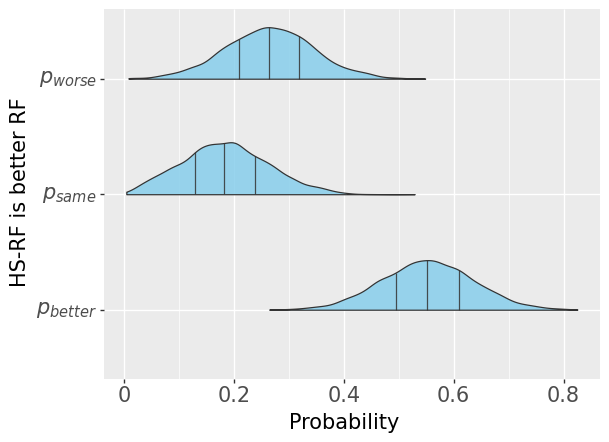

<ggplot: (8779240038076)>

/home/bro/anaconda3/envs/mlds/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 5 x 5 in image.
/home/bro/anaconda3/envs/mlds/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: graphs/rnd-rf.png
/home/bro/anaconda3/envs/mlds/lib/python3.10/site-packages/plotnine/utils.py:693: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
/home/bro/anaconda3/envs/mlds/lib/python3.10/site-packages/plotnine/utils.py:694: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use 

In [8]:
random = pd.read_csv("modelling/data/rf-random-res.csv")
random = random[["theta_upper[1]", "theta_upper[2]", "theta_upper[3]"]]

disp = pd.melt(random, value_vars=["theta_upper[1]", "theta_upper[2]", "theta_upper[3]"], value_name='sample')
disp.loc[disp.variable == "theta_upper[1]", "variable"] = "$p_{better}$"
disp.loc[disp.variable == "theta_upper[2]", "variable"] = "$p_{same}$"
disp.loc[disp.variable == "theta_upper[3]", "variable"] = "$p_{worse}$"

g = (
    ggplot(disp, aes(x="variable", y="sample"))
    + geom_violin(disp, draw_quantiles = [0.25, 0.5, 0.75], fill = "skyblue", alpha = 0.85, style = "right", position = position_dodge())
    # + geom_hline(yintercept = 0, linetype = "dashed", color = "red")
    + theme(text=element_text(size=15))
    + xlab("HS-RF is better RF")
    + ylab("Probability")
    # + geom_text(disp_mu, aes(x="parameters", y="value", label = "value_str"), nudge_x = -0.2, size = 10)
    + coord_flip()
    # + facet_wrap("var")
)
display(g)
g.save(filename = "graphs/rnd-rf.png", height = 5, width = 5, units = "in", dpi = 1000)

# Appendix A

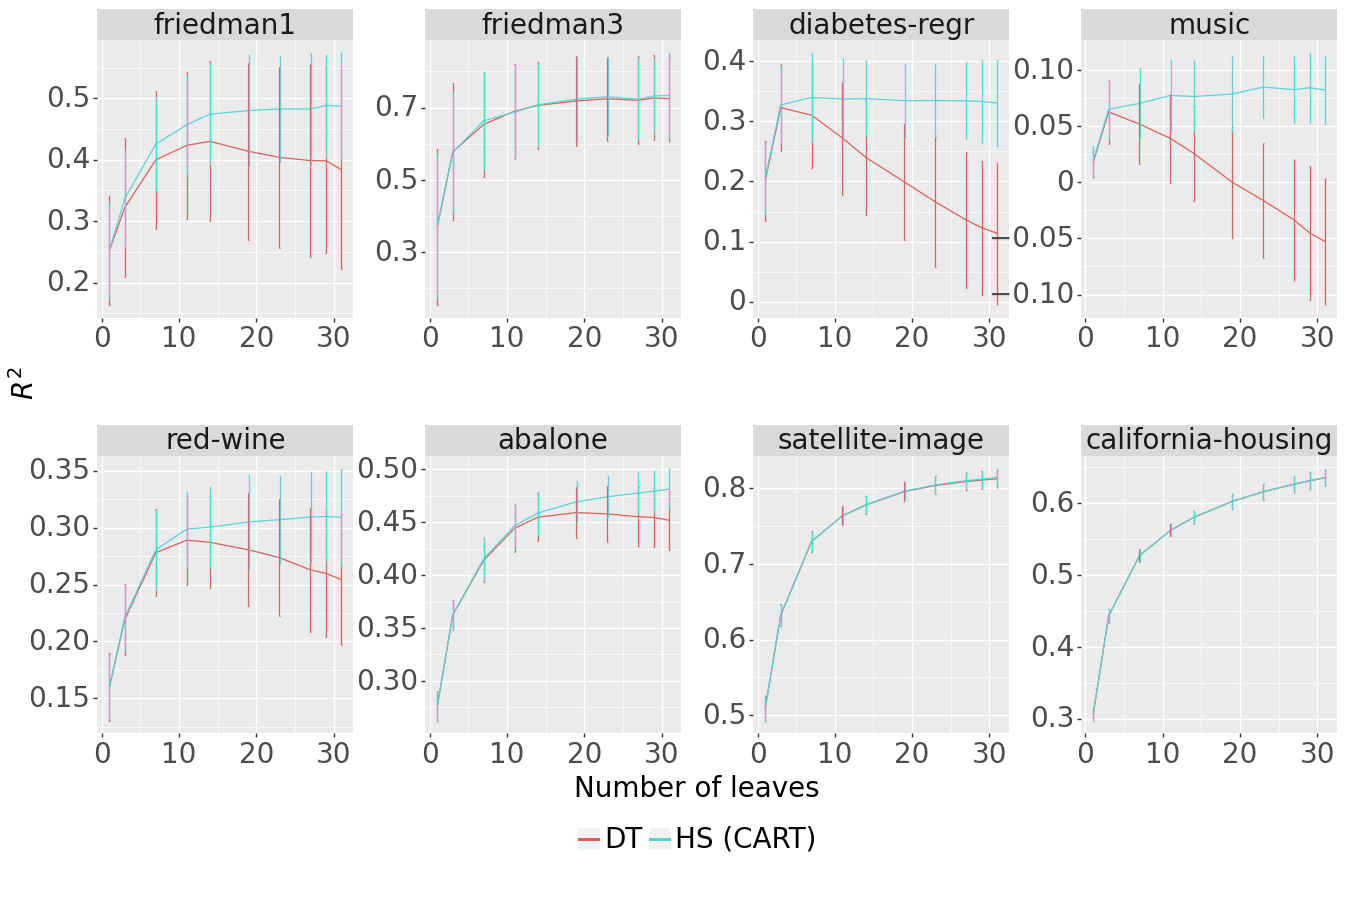

/home/bro/anaconda3/envs/mlds/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 20 x 5 in image.
/home/bro/anaconda3/envs/mlds/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: graphs/claim_1/regression_dt_1.png


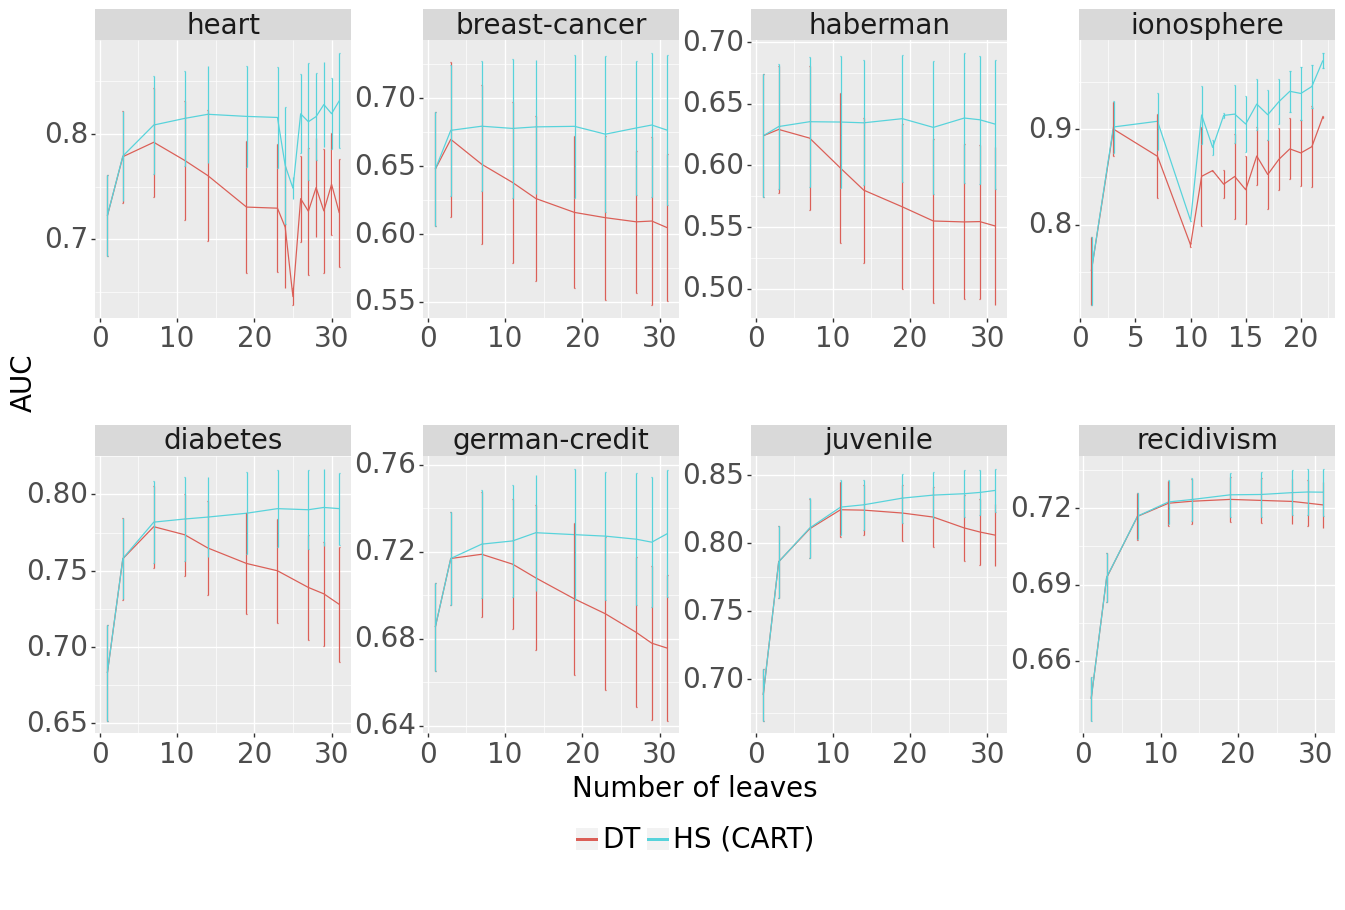

/home/bro/anaconda3/envs/mlds/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 20 x 5 in image.
/home/bro/anaconda3/envs/mlds/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: graphs/claim_1/classification_dt_1.png


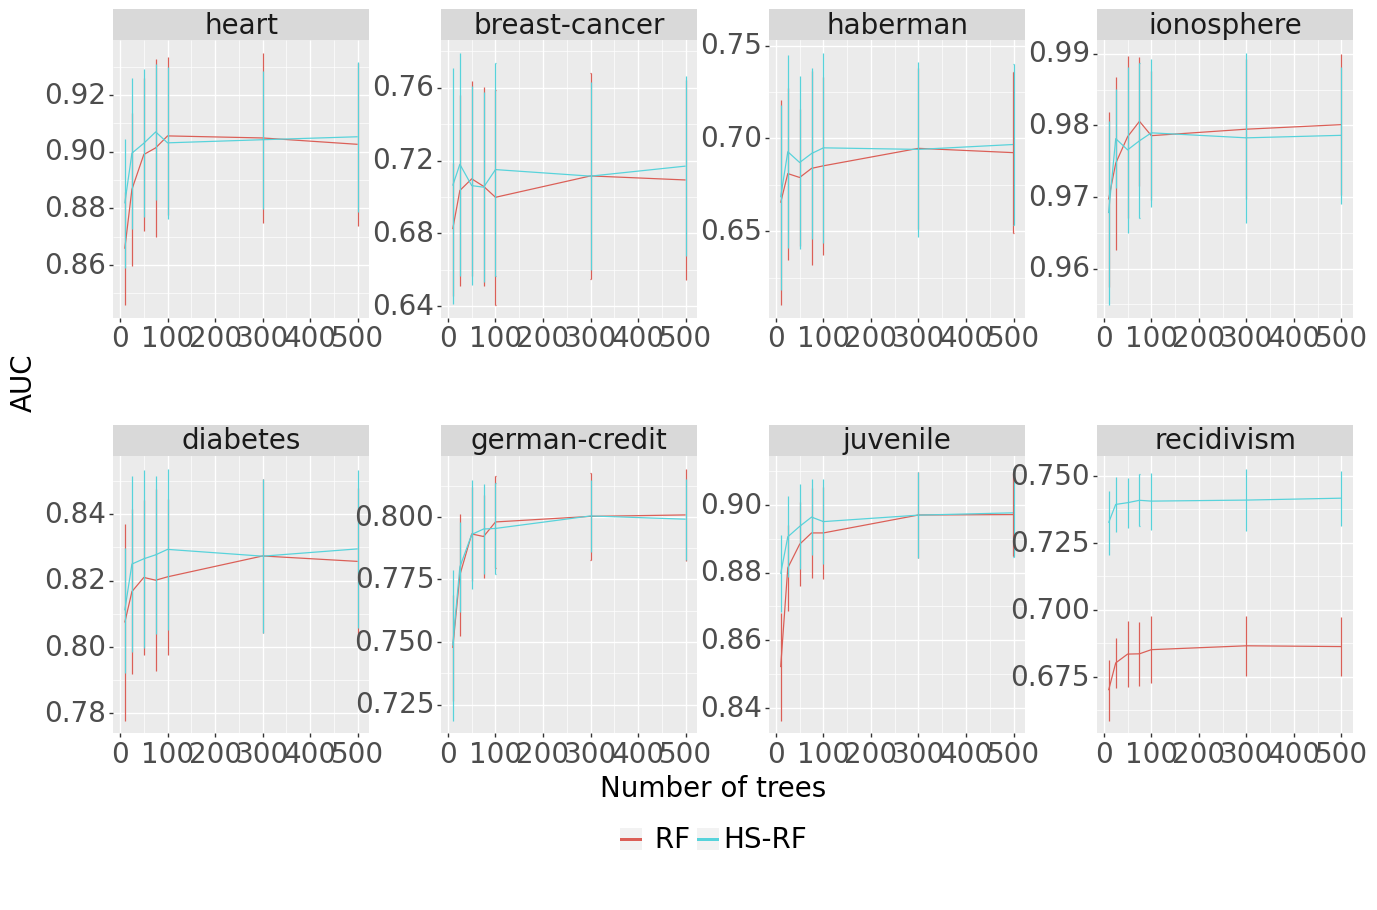

/home/bro/anaconda3/envs/mlds/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 20 x 5 in image.
/home/bro/anaconda3/envs/mlds/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: graphs/claim_1/classification_rf_1.png


In [9]:
# load regression dataset
regression = pd.read_csv("results/claim_1_1_dt_comparison_regression.csv")    
og_regression = regression.copy()

# plot results in similar fashion to the original paper
plot_fig_4(regression, REGRESSION_ORDER, target = "$R^2$", save_to = "graphs/claim_1/regression_dt_1.png")

# load classification dataset
classification = pd.read_csv("results/claim_1_1_dt_comparison_classification.csv")
og_classification = classification.copy()

# plot results in similar fashion to the original paper
plot_fig_4(classification, CLASSIFICATION_ORDER, target = "AUC", save_to = "graphs/claim_1/classification_dt_1.png")

# load rf-classification dataset
rf = pd.read_csv("results/rf_comparison_classification.csv").drop(['Unnamed: 0'], axis = 1)

# pick only relavant parts for this claim
rf = rf.loc[(rf["algorithm"] == "RF") | (rf["algorithm"] == "HS-RF")]
rf.loc[rf["algorithm"] == "RF"] = rf.loc[rf["algorithm"] == "RF"].replace("RF", " RF")
og_rf = rf.copy()

# plot results in similar fashion to the original paper
plot_fig_4(rf, CLASSIFICATION_ORDER, target = "AUC", save_to = "graphs/claim_1/classification_rf_1.png")

#### Comparison of algorithms

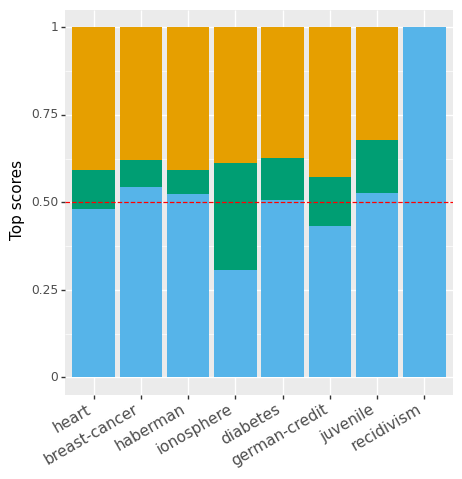

/home/bro/anaconda3/envs/mlds/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 5 x 5 in image.
/home/bro/anaconda3/envs/mlds/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: graphs/miscelenious/RF-top-class-likelihood.png


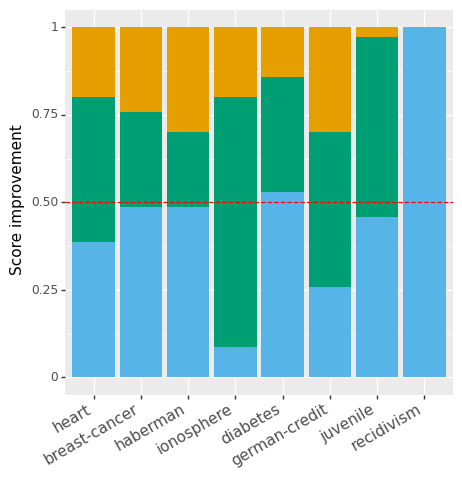

/home/bro/anaconda3/envs/mlds/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 5 x 5 in image.
/home/bro/anaconda3/envs/mlds/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: graphs/miscelenious/RF-any-class-likelihood.png


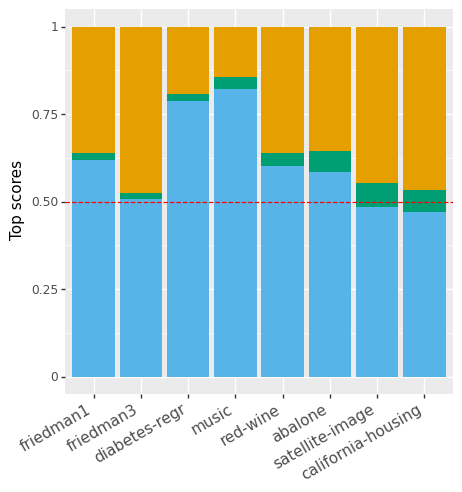

/home/bro/anaconda3/envs/mlds/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 5 x 5 in image.
/home/bro/anaconda3/envs/mlds/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: graphs/miscelenious/DT-top-reg-likelihood.png


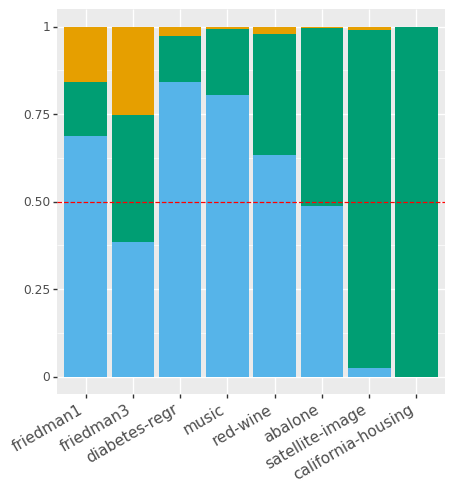

/home/bro/anaconda3/envs/mlds/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 5 x 5 in image.
/home/bro/anaconda3/envs/mlds/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: graphs/miscelenious/DT-any-reg-likelihood.png


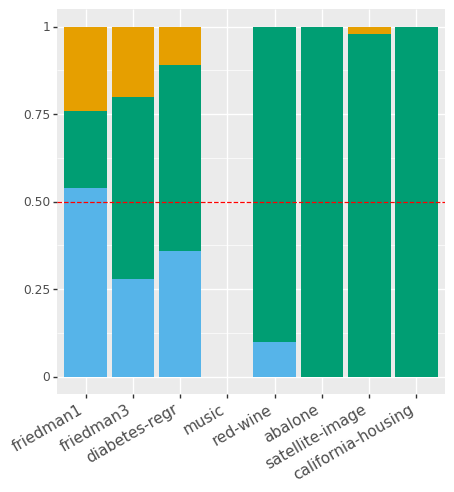

/home/bro/anaconda3/envs/mlds/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 5 x 5 in image.
/home/bro/anaconda3/envs/mlds/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: graphs/miscelenious/DT-heuristic-reg-likelihood.png


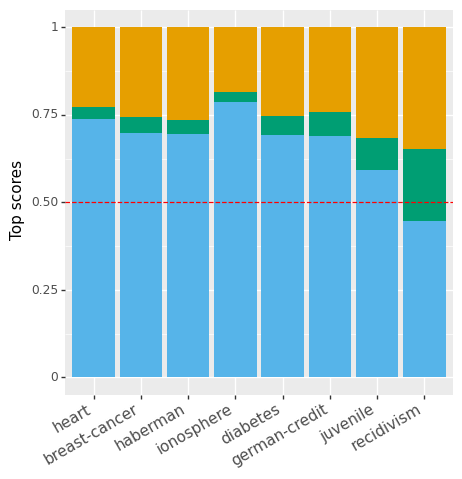

/home/bro/anaconda3/envs/mlds/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 5 x 5 in image.
/home/bro/anaconda3/envs/mlds/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: graphs/miscelenious/DT-top-class-likelihood.png


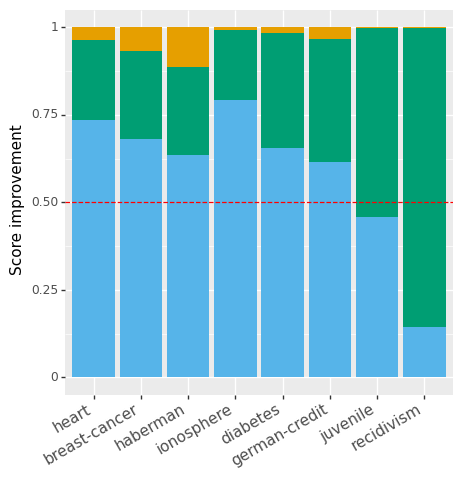

/home/bro/anaconda3/envs/mlds/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 5 x 5 in image.
/home/bro/anaconda3/envs/mlds/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: graphs/miscelenious/DT-any-class-likelihood.png


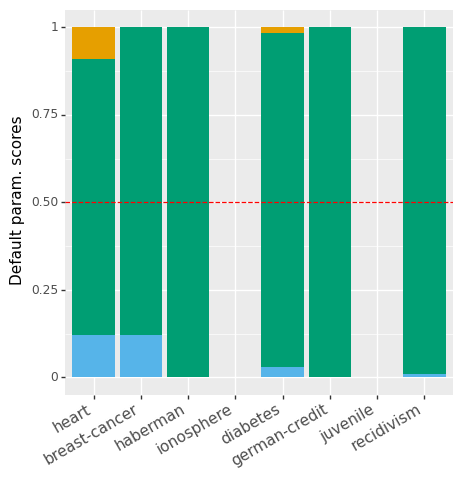

/home/bro/anaconda3/envs/mlds/lib/python3.10/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 5 x 5 in image.
/home/bro/anaconda3/envs/mlds/lib/python3.10/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: graphs/miscelenious/DT-heuristic-class-likelihood.png


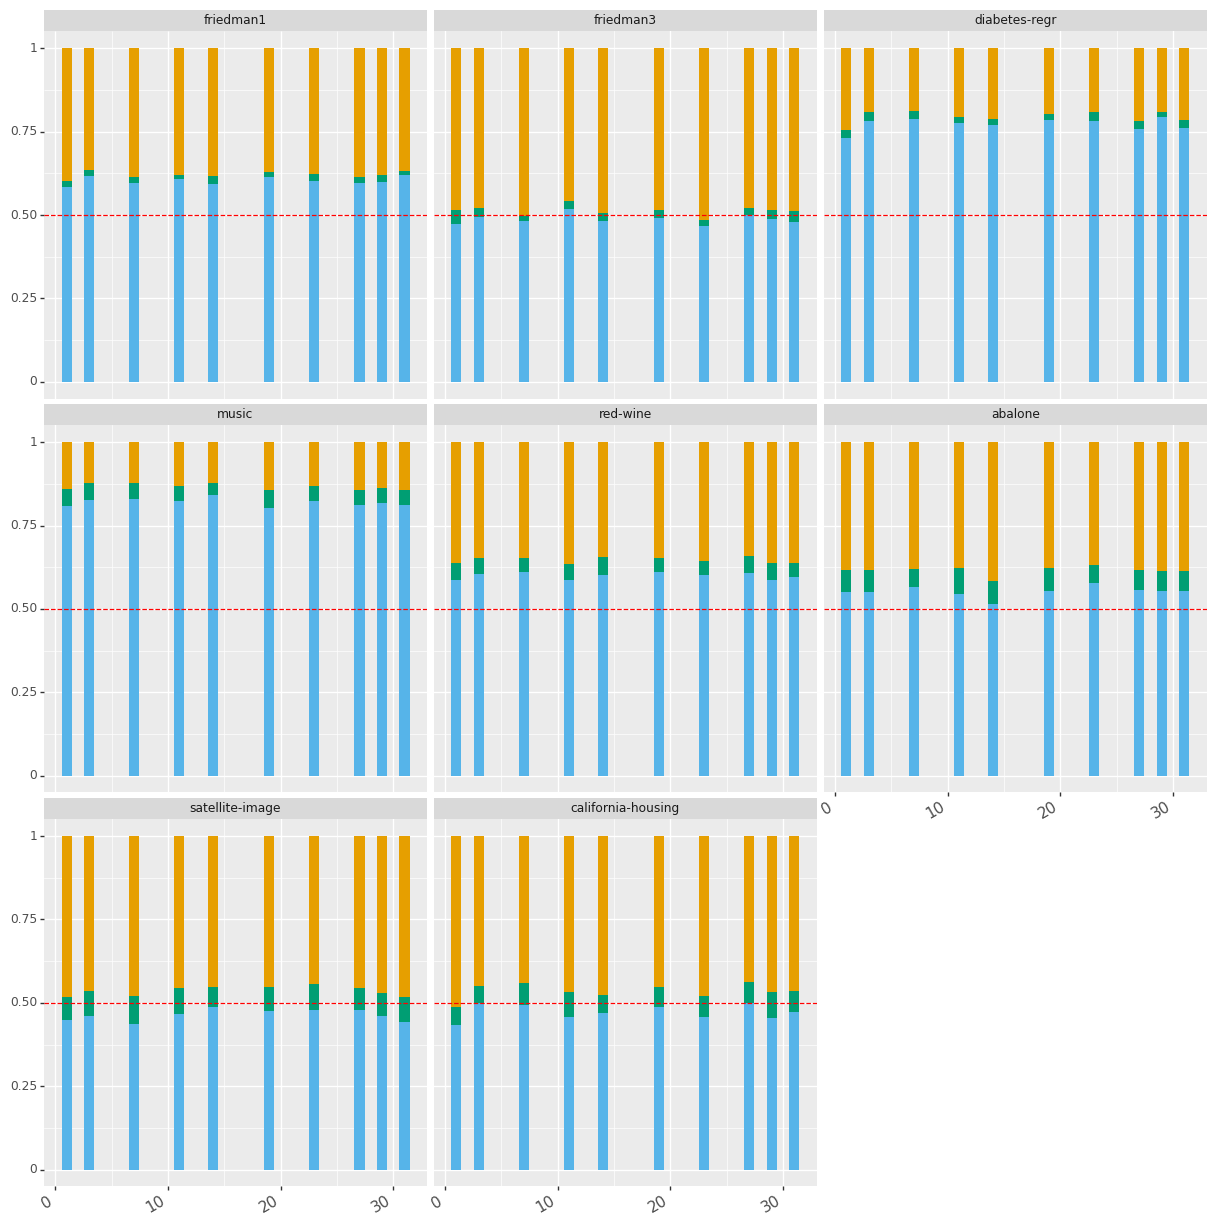

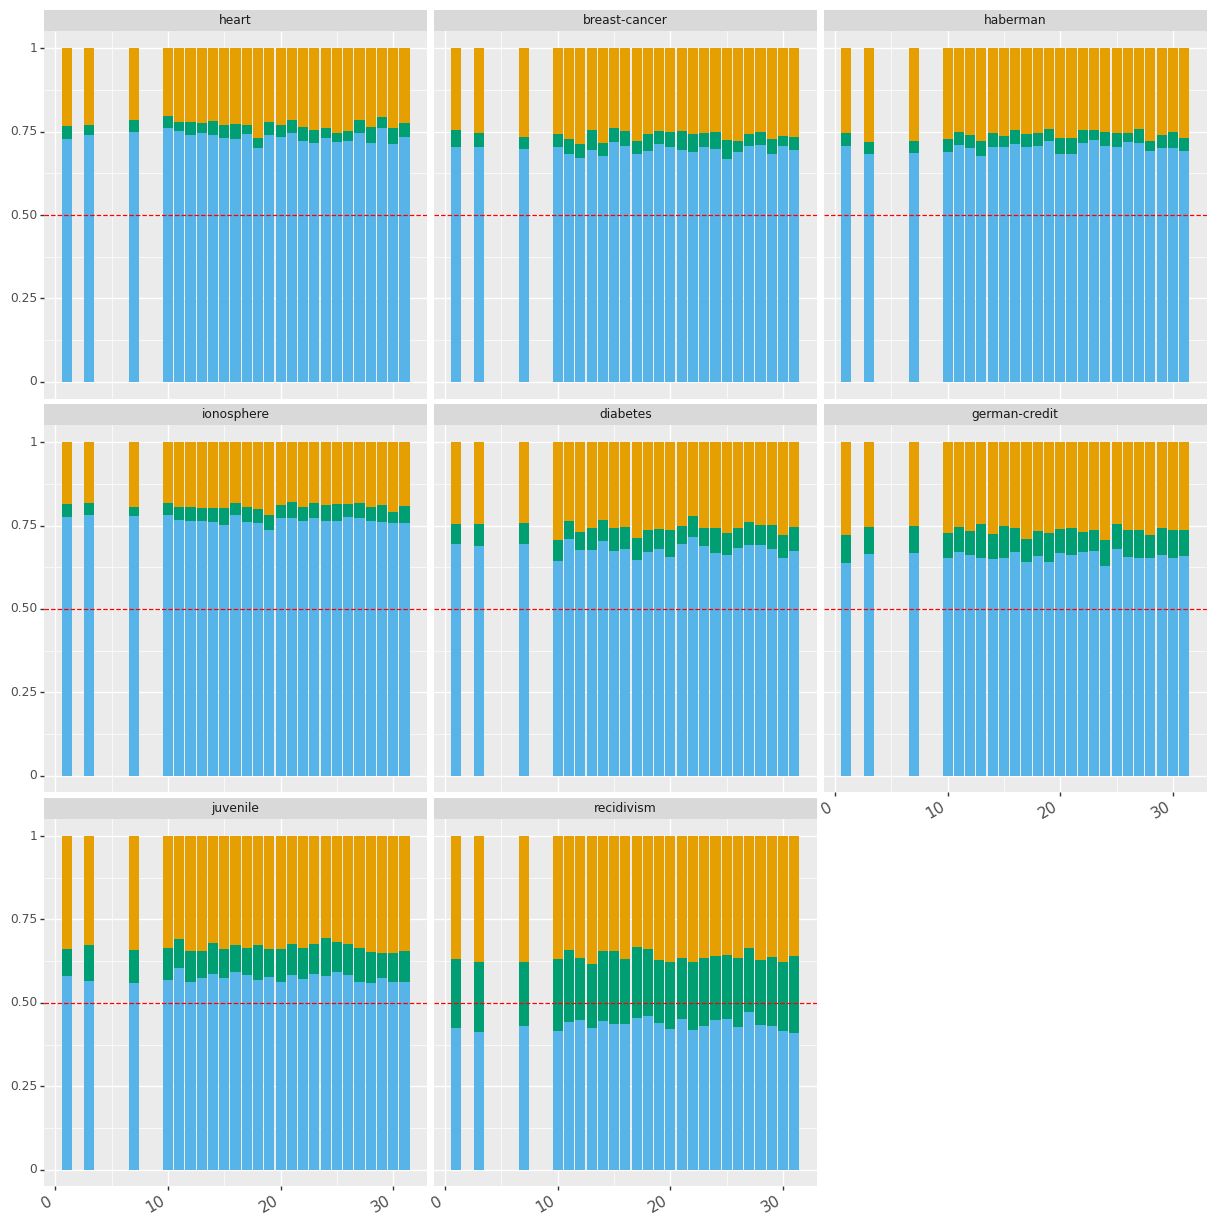

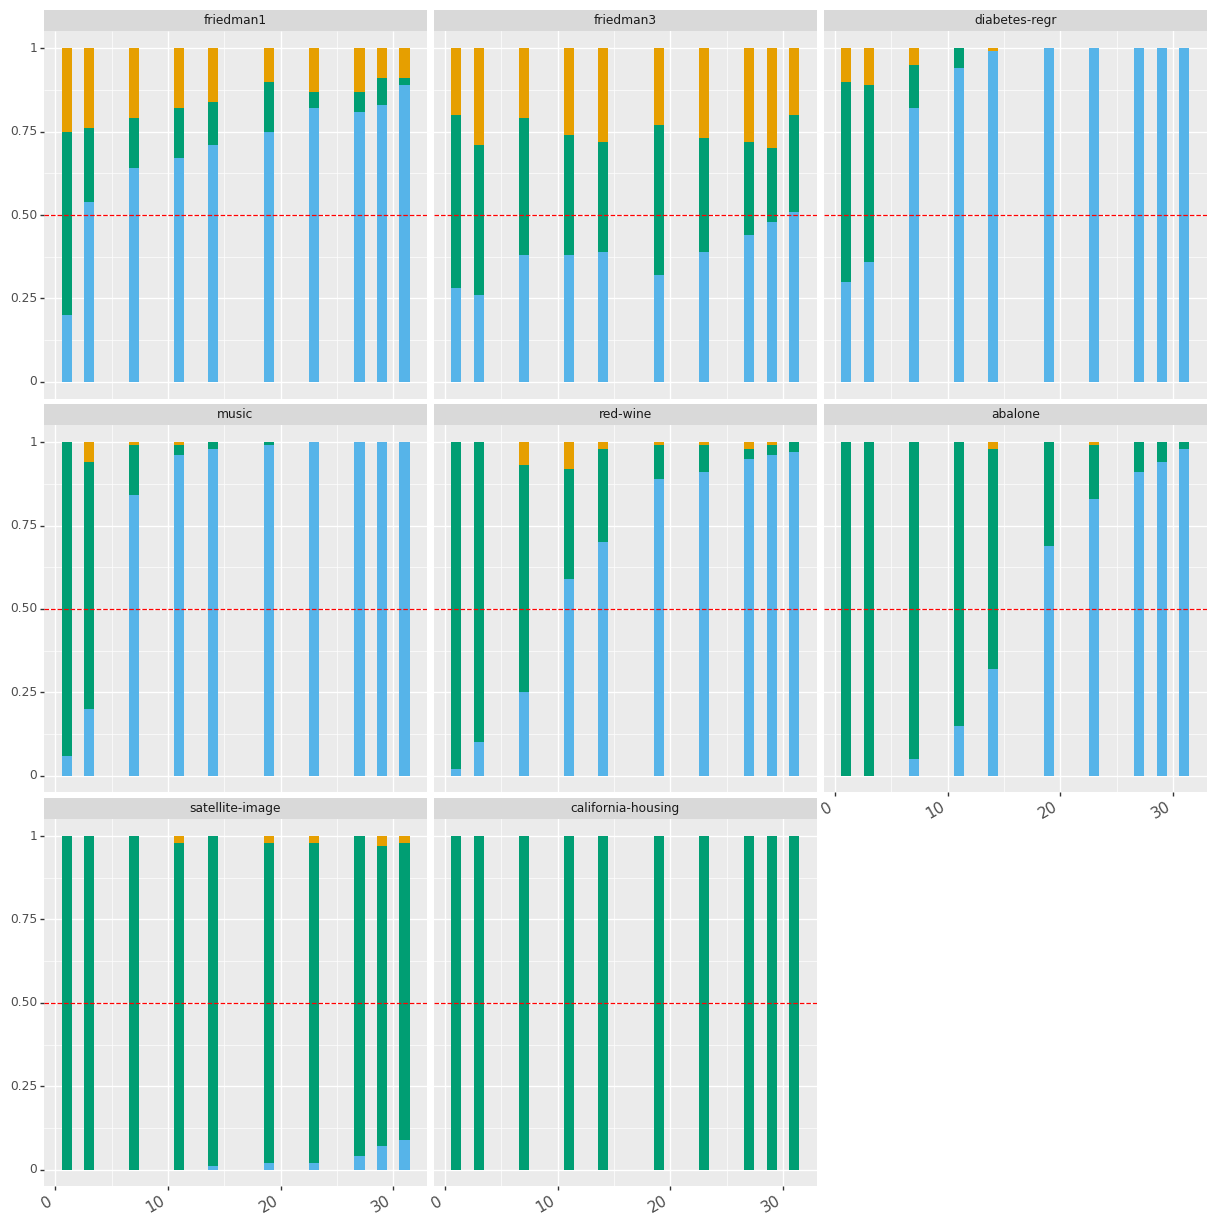

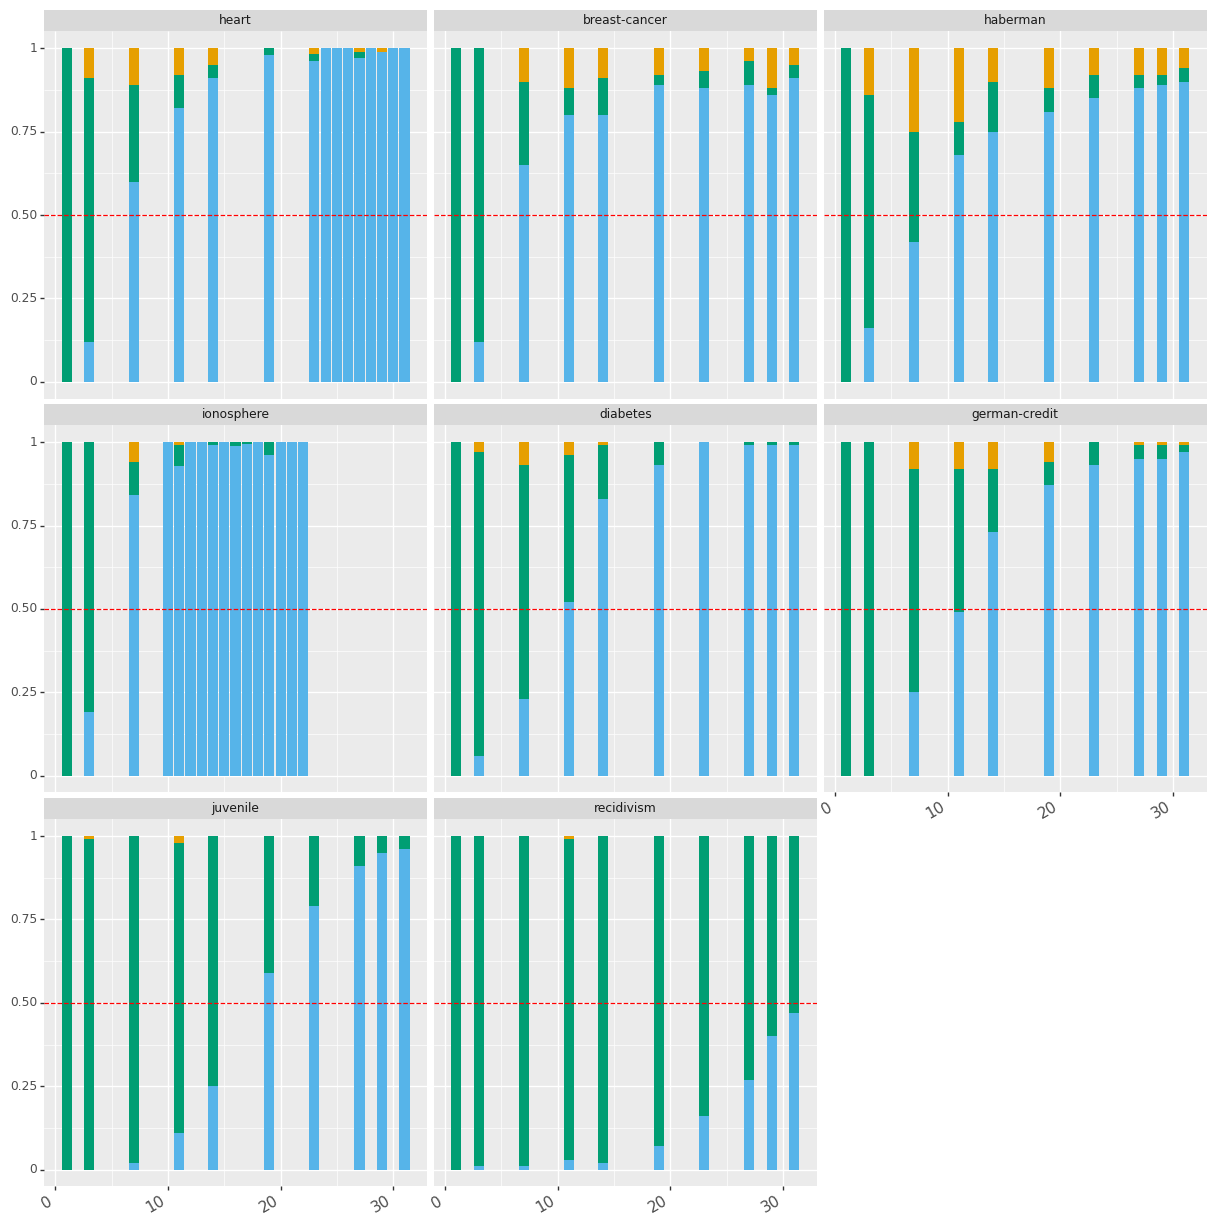

In [10]:
## Random Forests (RF)

### Classification

# plot likelihood that top results from HS are better than top results from DT
top_imp_disp = check_top_scores(rf, CLASSIFICATION_ORDER, Q_95, alg = "RF")
plot_comparison(top_imp_disp, target="Top scores", save_to = "graphs/miscelenious/RF-top-class-likelihood.png")

# plot likelihood of improvement when HS is applied to DT
imp_disp = check_improvement(rf, CLASSIFICATION_ORDER, alg = "RF")
plot_comparison(imp_disp, target="Score improvement", save_to = "graphs/miscelenious/RF-any-class-likelihood.png")

## Decision Trees (DT)

### Regression

# plot likelihood that top results from HS are better than top results from DT
top_imp_disp = check_top_scores(regression, REGRESSION_ORDER, Q_95)
plot_comparison(top_imp_disp, target="Top scores", save_to = "graphs/miscelenious/DT-top-reg-likelihood.png")

# plot likelihood of improvement when HS is applied to DT
imp_disp = check_improvement(regression, REGRESSION_ORDER)
plot_comparison(imp_disp, save_to = "graphs/miscelenious/DT-any-reg-likelihood.png")

# plot likelihood of improvement when HS is applied to DT when using default parameters (heuristics)
heuristic_imp_disp = check_heuristic(regression, REGRESSION_ORDER, regression_heuristic, TOL_LEAF)
plot_comparison(heuristic_imp_disp, save_to = "graphs/miscelenious/DT-heuristic-reg-likelihood.png")

### Classification

# plot likelihood that top results from HS are better than top results from DT
top_imp_disp = check_top_scores(classification, CLASSIFICATION_ORDER, Q_95)
plot_comparison(top_imp_disp, target="Top scores", save_to = "graphs/miscelenious/DT-top-class-likelihood.png")

# plot likelihood of improvement when HS is applied to DT
imp_disp = check_improvement(classification, CLASSIFICATION_ORDER)
plot_comparison(imp_disp, target="Score improvement", save_to = "graphs/miscelenious/DT-any-class-likelihood.png")

# plot likelihood of improvement when HS is applied to DT when using default parameters (heuristics)
heuristic_imp_disp = check_heuristic(classification, CLASSIFICATION_ORDER, classification_heuristic, TOL_LEAF)
plot_comparison(heuristic_imp_disp, target="Default param. scores", save_to = "graphs/miscelenious/DT-heuristic-class-likelihood.png")

### for regression

# comparison of random samples from HS and DT
leaf_imp_disp = comparison_rnd_by_x(regression, REGRESSION_ORDER)
plot_comparison_x(leaf_imp_disp, target = "", save_to = None)

### for classification

# comparison of random samples from HS and DT
leaf_imp_disp = comparison_rnd_by_x(classification, CLASSIFICATION_ORDER)
plot_comparison_x(leaf_imp_disp, target = "", save_to = None)

### for regression

# comparison of HS improvement for each leaf across all datasets
leaf_imp_disp = check_improvement_by_x(regression, REGRESSION_ORDER)
plot_comparison_x(leaf_imp_disp, target = "", save_to = None)

### for classification

# comparison of HS improvement for each leaf across all datasets
leaf_imp_disp = check_improvement_by_x(classification, CLASSIFICATION_ORDER)
plot_comparison_x(leaf_imp_disp, target = "", save_to = None)